In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cpsplines.fittings.fit_cpsplines import CPsplines
from cpsplines.psplines.bspline_basis import BsplineBasis
from cpsplines.psplines.penalty_matrix import PenaltyMatrix
from scipy.optimize import minimize

In [2]:
np.random.seed(5)
n = 201  # Número de observaciones
scale = 0.1  # Desviación estándar del error
deg = 3  # Grado de la base de splines
k = 10  # Número de nodos

# Genera datos ruidosos
a, b = 0.05, 5
x = np.linspace(a, b, n)
y = np.log(x)
y[2:-2] += np.random.normal(loc=0.0, scale=scale, size=n - 4)

In [3]:
# Define la base de B-splines con nodos equiespaciados
# (¡incluso fuera del intervalo [a,b]!)
bspline = BsplineBasis(xsample=x, deg=deg, n_int=10)
bspline.get_matrix_B()
# La base B contiene qué vale cada spline de la base en cada punto de x
B = bspline.matrixB
# Definimos la penalización
penalty = PenaltyMatrix(bspline=bspline)
D = penalty.get_diff_matrix(ord_d=2)
# Definimos un parámetro de suavizado (lo normal sería tunearlo mediante validación
# cruzada, pero lo fijamos aquí por sencillez)
sp = 1.23
# Estimamos la variable respuesta mediante mínimos cuadrados penalizados
y_hat = B @ np.linalg.solve(B.T @ B + sp * D.T @ D, B.T @ y)

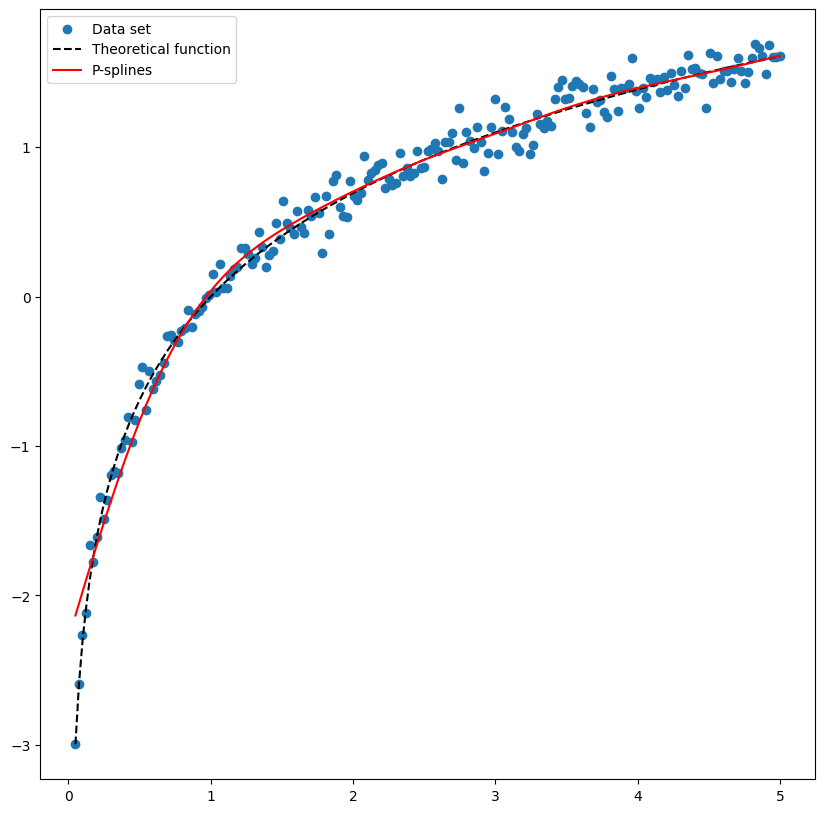

In [4]:
fig, ax = plt.subplots(figsize=(10, 10))
ax: plt.Axes
_ = ax.scatter(x, y, label="Data set")
_ = ax.plot(x, np.log(x), "k--", label="Theoretical function")
_ = ax.plot(x, y_hat, "r", label="P-splines")
_ = ax.legend()

In [5]:
# Obtendríamos lo mismo que antes usando la función CPsplines
cps = CPsplines(
    deg=(deg,),
    ord_d=(2,),
    n_int=(k,),
    sp_method="grid_search",
    sp_args={"grid": ((sp,),)},
)
cps.fit(data=pd.DataFrame({"x": x, "y": y}), y_col="y")
y_hat2 = cps.predict(pd.Series(x))
# Los datos pueden diferir ligeramente, ya que un método resuelve los mínimos cuadrados
# directamente mientras que el otro resuelve el problema cuadrático mediante solvers de
# optimización (MOSEK, en este caso)
assert np.allclose(y_hat, y_hat2, atol=1e-5)

[Solve the problem with smoothing parameters (1.23,): ] Elapsed time (s): 0.021072


In [6]:
# Podemos hacer lo mismo con scipy
def cost_function(beta, X, D, sp, y):
    residuals = y - X.dot(beta)
    return np.sum(residuals**2) + sp * beta.T @ D.T @ D @ beta


result = minimize(
    cost_function, np.zeros(B.shape[1]), args=(B, D, sp, y), method="SLSQP"
)
assert np.allclose(y_hat, B @ result.x, atol=1e-5)

In [7]:
print(
    f"f(a) - pspl(a)  = {np.log(a)  - np.dot(bspline.bspline_basis(x=a, nu=0), cps.sol)}"
)
print(f"f'(a)- pspl'(a) = {1/a - np.dot(bspline.bspline_basis(x=a, nu=1), cps.sol)}")
print(
    f"f(b) - pspl(b)  = {np.log(b)  - np.dot(bspline.bspline_basis(x=b, nu=0), cps.sol)}"
)
print(f"f'(b)- pspl'(b) = {1/b - np.dot(bspline.bspline_basis(x=b, nu=1), cps.sol)}")

f(a) - pspl(a)  = -0.862021115909549
f'(a)- pspl'(a) = 16.782660412339602
f(b) - pspl(b)  = -0.0029066614715524963
f'(b)- pspl'(b) = -0.03829597967972348


In [8]:
# Obtendríamos lo mismo que antes usando la función CPsplines
cps = CPsplines(
    deg=(deg,),
    ord_d=(2,),
    n_int=(k,),
    sp_method="grid_search",
    sp_args={"grid": ((sp,),)},
    pt_constraints={
        (0,): {"equalsTo": pd.DataFrame({"x": [a, b], "y": [np.log(a), np.log(b)]})},
        (1,): {"equalsTo": pd.DataFrame({"x": [a, b], "y": [1 / a, 1 / b]})},
    },
)
# El (0,) quiere decir que imponemos las restricciones en la derivada 0, es decir, en la
# función normal. El (1,) quiere decir primera derivada
cps.fit(data=pd.DataFrame({"x": x, "y": y}), y_col="y")

[Solve the problem with smoothing parameters (1.23,): ] Elapsed time (s): 0.027672


In [9]:
print(
    f"f(a) - pspl(a) = {np.log(a)  - np.dot(bspline.bspline_basis(x=a, nu=0), cps.sol)}"
)
print(f"f'(a)- pspl'(a) = {1/a - np.dot(bspline.bspline_basis(x=a, nu=1), cps.sol)}")
print(
    f"f(b) - pspl(b) = {np.log(b)  - np.dot(bspline.bspline_basis(x=b, nu=0), cps.sol)}"
)
print(f"f'(b)- pspl'(b) = {1/b - np.dot(bspline.bspline_basis(x=b, nu=1), cps.sol)}")

f(a) - pspl(a) = -8.881784197001252e-16
f'(a)- pspl'(a) = 3.552713678800501e-15
f(b) - pspl(b) = 0.0
f'(b)- pspl'(b) = 2.9976021664879227e-15


In [10]:
# Podemos hacer lo mismo con scipy, al tratarse de restricciones lineales
def constraint1(beta):
    return np.dot(bspline.bspline_basis(x=a, nu=0), beta) - np.log(a)


def constraint2(beta):
    return np.dot(bspline.bspline_basis(x=b, nu=0), beta) - np.log(b)


def constraint3(beta):
    return np.dot(bspline.bspline_basis(x=a, nu=1), beta) - 1 / a


def constraint4(beta):
    return np.dot(bspline.bspline_basis(x=b, nu=1), beta) - 1 / b


constraints = (
    {"type": "eq", "fun": constraint1},
    {"type": "eq", "fun": constraint2},
    {"type": "eq", "fun": constraint3},
    {"type": "eq", "fun": constraint4},
)

result = minimize(
    cost_function,
    np.zeros(B.shape[1]),
    args=(B, D, sp, y),
    method="SLSQP",
    constraints=constraints,
)

In [11]:
print(
    f"f(a) - pspl(a) = {np.log(a)  - np.dot(bspline.bspline_basis(x=a, nu=0), result.x)}"
)
print(f"f'(a)- pspl'(a) = {1/a - np.dot(bspline.bspline_basis(x=a, nu=1), result.x)}")
print(
    f"f(b) - pspl(b) = {np.log(b)  - np.dot(bspline.bspline_basis(x=b, nu=0), result.x)}"
)
print(f"f'(b)- pspl'(b) = {1/b - np.dot(bspline.bspline_basis(x=b, nu=1), result.x)}")

f(a) - pspl(a) = -1.6788348489171767e-11
f'(a)- pspl'(a) = 3.552713678800501e-15
f(b) - pspl(b) = 1.0375700298936863e-11
f'(b)- pspl'(b) = 5.1877946383172e-12
